In [75]:
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from datetime import datetime
from sklearn.svm import SVC
import operator
import googlefinance.client as gfc
from matplotlib import pyplot as plt
%matplotlib notebook

The goal of this notebook is to create time series regression models using some regression models as well as "Forest" models (both regression and deep learning versions). 

The features for this part of the research are going to be extracted using data freely available in Python via Quandl and pandas Yahoo finance support. 

- NASDAQ Composite
- Dow Jones Industrial Average
- Frankfurt DAX
- London FTSE-100
- Paris CAC 40
- Tokyo Nikkei-225
- Hong Kong Hang Seng
- Australia ASX-200

The features will be extracted from the major market indicators above will have the following format:

- Date : in days

- Open : price of the stock at the opening of the trading (in US dollars)
- High : highest price of the stock during the day (in US dollars)
- Low : lowest price of the stock during the trading day (in US dollars)
- Close : price of the stock at the closing of the trading (in US dollars)
- Volume : amount of stocks traded (in US dollars)
- Adj Close : price of the stock at the closing of the trading adjusted with dividends (in US dollars)

In [56]:
params = [
    {'q': "IXIC",
     'x': 'INDEXNASDAQ'
    },
    {'q': '.DJI',
      'x': 'INDEXDJX'  
    },
    {'q':'DAX',
     'x':'INDEXDB'   
    },
    {'q': 'UKX',
      'x':'INDEXFTSE'   
    },
    {'q': 'PX1',
      'x': 'INDEXEURO'   
    },
    {'q': 'NI225',
      'x': 'INDEXNIKKEI'  
    },
    {'q': 'HSI',
      'x': 'INDEXHANGSENG'  
    },
    {'q': 'XJO',
      'x':'INDEXASX'   
    }
]
period = "3Y"
# get closing price data (return pandas dataframe)
df = gfc.get_closing_data(params, period)
df.head()

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO
2014-08-29,4580.271388,17098.45,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-01,NaN,NaN,9479.03,6825.31,4379.73,15476.60,24752.09,5629.8
2014-09-02,4598.187822,17067.56,9507.02,6829.17,4378.33,15668.60,24749.02,5658.5
2014-09-03,4572.565131,17078.28,9626.49,6873.58,4421.87,15728.35,25317.95,5656.1
2014-09-04,4562.286956,17069.58,9724.26,6877.97,4494.94,15676.18,25297.92,5631.3


In [65]:
pct_change = df.pct_change()

In [69]:
log_returns = np.log(df) - np.log(df.shift(1))

In [67]:
pct_change.head()

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO
2014-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-02,0.003912,-0.001807,0.002953,0.000566,-0.000320,0.012406,-0.000124,0.005098
2014-09-03,-0.005572,0.000628,0.012567,0.006503,0.009944,0.003813,0.022988,-0.000424
2014-09-04,-0.002248,-0.000509,0.010156,0.000639,0.016525,-0.003317,-0.000791,-0.004385


In [71]:
log_returns.head()

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO
2014-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-02,NaN,NaN,0.002948,0.000565,-0.000320,0.012330,-0.000124,0.005085
2014-09-03,-0.005588,0.000628,0.012488,0.006482,0.009895,0.003806,0.022728,-0.000424
2014-09-04,-0.002250,-0.000510,0.010105,0.000638,0.016390,-0.003322,-0.000791,-0.004394


In [91]:
df.corr(method='spearman')

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO
IXIC,1.000000,0.916420,0.846101,0.793559,0.725153,0.586771,0.441458,0.597822
.DJI,0.916420,1.000000,0.784960,0.867962,0.614819,0.436603,0.490412,0.702673
DAX,0.846101,0.784960,1.000000,0.819001,0.947692,0.815117,0.669121,0.786739
UKX,0.793559,0.867962,0.819001,1.000000,0.709647,0.516642,0.747407,0.866581
PX1,0.725153,0.614819,0.947692,0.709647,1.000000,0.876066,0.682954,0.711668
NI225,0.586771,0.436603,0.815117,0.516642,0.876066,1.000000,0.639252,0.543250
HSI,0.441458,0.490412,0.669121,0.747407,0.682954,0.639252,1.000000,0.787407
XJO,0.597822,0.702673,0.786739,0.866581,0.711668,0.543250,0.787407,1.000000


In [92]:
df.corr(method='kendall')

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO
IXIC,1.000000,0.770279,0.665585,0.616338,0.538765,0.428763,0.336907,0.421242
.DJI,0.770279,1.000000,0.590905,0.685282,0.441198,0.308697,0.353353,0.507042
DAX,0.665585,0.590905,1.000000,0.632286,0.801019,0.599393,0.483148,0.575522
UKX,0.616338,0.685282,0.632286,1.000000,0.529382,0.358225,0.561156,0.670111
PX1,0.538765,0.441198,0.801019,0.529382,1.000000,0.675084,0.487236,0.498600
NI225,0.428763,0.308697,0.599393,0.358225,0.675084,1.000000,0.450917,0.335248
HSI,0.336907,0.353353,0.483148,0.561156,0.487236,0.450917,1.000000,0.576451
XJO,0.421242,0.507042,0.575522,0.670111,0.498600,0.335248,0.576451,1.000000


<IPython.core.display.Javascript object>


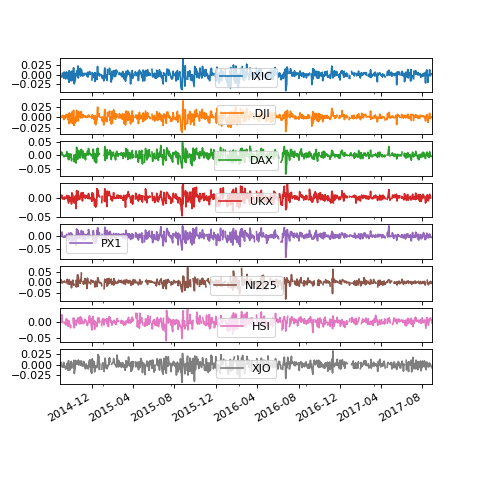

In [94]:
log_returns.plot(subplots=True, figsize=(6, 6));